In [1]:
import numpy as np 
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from numba import jit

import matplotlib.pyplot as plt
# %matplotlib notebook

import cProfile

from MCML import mlmc

In [2]:
%%time
e_Td = (np.loadtxt('Trans.dat') * np.array([1,100])).transpose()
e_Rd = (np.loadtxt('Refl.dat') * np.array([1,100]) - np.array([0,0.7])).transpose()

thickness = np.array([1.04, 0.2, 0.18])

geometry = [
            {'z_start': 0, 'z_end': thickness[0], 
             'mu_a': 0, 'mu_s': 1, 'g': 1, 'n': 1.5},
            {'z_start': thickness[0], 'z_end': thickness[0] + thickness[1], 
             'mu_a': 1.568, 'mu_s': 12.72, 'g': 0.9376, 'n': 1.4},
            {'z_start': thickness[0] + thickness[1], 'z_end': thickness[0] + thickness[1] + thickness[2], 
             'mu_a': 0, 'mu_s': 1, 'g': 1, 'n': 1.5}
           ]

parameters = {'N': 10000, 
              'generator_distribution': 'Gauss', # Gauss // Cyrcle
              'absorbtion_saving_mode': 'Full', # Full // Mapping(to do)
              'radiation_saving_mode': 'MIS_Thorlabs', # FIS // MIS // MIS_Thorlabs // Rings(to do)
              'FIS_collimated_aperture': 0.984,
              'MIS_positions_table': e_Td[0]
             }

output_MIS = mlmc(parameters, geometry)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(e_Td[0],e_Td[1])
ax2.plot(e_Rd[0],e_Rd[1])
ax1.plot(output_MIS['radiation_output'][0],output_MIS['radiation_output'][1])
ax2.plot(output_MIS['radiation_output'][0],output_MIS['radiation_output'][2])

: 

: 

mu_t_0 =  14.01544180643701  mm-1


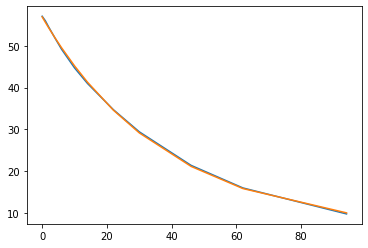

In [50]:
# mu_t fitting 3 layers sample (glass - tissue - glass)

def model_mu_t(z, mu_t, amplitude, z_att):
    n_table = np.array([geometry[i]['n']  for i in range(len(geometry))])
    
    def tr(n1, n2):
        return 1 - ((n2-n1) / (n2+n1))**2
    transmition = tr(n_table[0], 1) * tr(n_table[1], n_table[0]) * tr(n_table[2], n_table[1]) * tr(1, n_table[2])  

    return 100 * (np.exp(- mu_t * (geometry[1]['z_end'] - geometry[1]['z_start'])) * transmition + 
                  amplitude * np.exp(-z/z_att))

p_opt, p_cov = curve_fit(model_mu_t, e_Td[0], e_Td[1])

mu_t_0 = p_opt[0]
print('mu_t_0 = ',mu_t_0, ' mm-1')

plt.plot(e_Td[0], e_Td[1])
plt.plot(e_Td[0], model_mu_t(e_Td[0], *p_opt))
plt.show()

In [101]:
# start parameters

g_0 = 0.94
l_mu_t_0 = mu_t_0 * thickness[1]
l_mu_ss_0 = (mu_t_0 - 1) * (1-g_0) * thickness[1]
print('l_mu_t_0 = ',l_mu_t_0 , ', l_mu_ss_0 = ',l_mu_ss_0,', g_0 = ', g_0)

# error function
def error(x):
    l_mu_t, l_mu_ss, g = x[0], x[1], x[2]
    dz = (geometry[1]['z_end'] - geometry[1]['z_start'])
    mu_s = l_mu_ss / (1 - g) / dz
    mu_a = l_mu_t / dz - mu_s
    
    geometry[1]['g'] = g
    geometry[1]['mu_s'] = mu_s
    geometry[1]['mu_a'] = mu_a
    
    output_MIS = mlmc(parameters, geometry)
    
    print(mu_a, mu_s, g)
    err = np.sum((np.log10(output_MIS['radiation_output'][1]) - np.log10(e_Td[1]))**2)
    print(err)
    return err

l_mu_t_0 =  2.8030883612874025 , l_mu_ss_0 =  0.1561853016772443 , g_0 =  0.94


In [102]:
res = minimize(error, [l_mu_t_0, l_mu_ss_0, g_0], method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

1.0000000000000018 13.015441806437014 0.94
0.0483220295251968
1.700772090321852 13.015441806437014 0.94
0.013907140198472284
0.349227909678147 13.666213896758869 0.94
0.1776776070116895
-46.055828069426134 60.07126987586315 0.987
inf
6.940965330834491 7.541657869150422 0.8929999999999999
4.843530589239576
4.779604245659307 9.586223605938633 0.9164999999999999
1.6535863066120808
-7.44130337365384 21.573540528477828 0.9635
3855.8505105290437
3.1966871719094403 11.11074300549501 0.9282499999999999
0.43519951381141037
-2.196683093076805 16.387317922094283 0.95175
149.7941924269598
2.20128438898381 12.0769469513239 0.9341249999999999
0.0839234234378455
2.8981015265277783 11.759714696037596 0.9360833333333332
0.20446304812207383
1.0094063743023973 13.166629036166707 0.9390208333333332
0.03545387232446034
0.07063120982461157 14.25626485897767 0.9452222222222222
0.31181640474308464
1.7404835415698727 12.54991398086148 0.9368993055555555
0.018947921980586115
1.971789608953534 12.801199804382328

1.5687211773240737 12.720553886544737 0.9376376695050873
0.008415344146744051
1.5687031052408624 12.720582233907285 0.9376378416883828
0.007176522935993089
1.5687178139451134 12.720543011757975 0.937637615948578
0.01046062433643916
1.5687158457814103 12.720561996763502 0.9376376980446597
0.006947972248464954
1.568708928056454 12.720556528773471 0.9376376635145319
0.009829659075715584
1.5687181150071083 12.720554547101981 0.9376376680074485
0.010273229737148986
1.5687210263579292 12.72054169459205 0.937637578920523
0.009116833151465874


Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x00000173E0BB5CA0>
Traceback (most recent call last):
  File "D:\Programm\Anaconda\lib\site-packages\llvmlite\binding\executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


1.5687146561420189 12.720551813109578 0.9376376507423846
0.008885600548389301
1.5687236921177856 12.720537639494141 0.9376375646507369
0.006673916110093795
1.568722010414552 12.720532202114512 0.937637537872482
0.006041591429803814
1.5687225024381526 12.720527455880454 0.9376375173484617
0.007184042125385528
1.5687332833711523 12.720509009707936 0.9376373908040191
0.01010806942713255
1.568719312982756 12.720541112225712 0.9376375857577932
0.009017524971457972
1.568724108639092 12.720526797302961 0.9376374988344343
0.008652235398527304
1.5687228512667417 12.720534920803756 0.9376375512616095
0.008609841217398422
1.5687183332871584 12.720542007603171 0.9376375943074333
0.007362049291406604
1.5687180213239476 12.720545956393924 0.9376376234599155
0.007890908609993445
1.5687160587513738 12.720545189936304 0.9376376191649443
0.00752866253800256


KeyboardInterrupt: 